In [ ]:
#auto-complete
%config Completer.use_jedi = False

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
%cd /content/drive/My Drive/Colab Notebooks
!ls

/content/drive/.shortcut-targets-by-id/1aYBNOEJ8TLvXsL9iSxrW2qj-KI3HpV4m/Colab Notebooks
 4243_miniProject_junyuan_baseline_dropout.ipynb
 4243_miniProject_junyuan_baseline.ipynb
 4243_miniProject_junyuan_baseline_regularization.ipynb
 4243_miniProject_junyuan_baseline_shuffle.ipynb
 4243_miniProject_junyuan_baseline_sobel.ipynb
 4243_miniProject_junyuan_baseline例子.ipynb
 4243_miniProject_junyuan_better.ipynb
 4243_miniProject_junyuan_better.ipynb（副本）
 4243_miniProject_junyuan_better_self.ipynb
 4243_miniProject_junyuan_better_teacher_model.ipynb
 4243_miniProject_junyuan_with_augmentation.ipynb
 baseline_trained
 baseline_trained_dropout
 baseline_trained_dropout0.5_batchNorm
 baseline_trained_regularization
 baseline_trained_shuffle
 baseline_trained_sobel
 better_trained
 better_trained_2
 ComputerVision4243
'Copy of 4243_miniProject_junyuan_baseline_dropout.ipynb（副本）'
 CS4243.gdoc
 cs4243NEWdata
 cs4243_smallest
 cs4243_smallest_a
 model.png


In [ ]:
# img, label 

In [43]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

img_height = 256
img_width = 256
image_size = (img_height, img_width)
batch_size = 32
epochs=10

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/Colab Notebooks/cs4243NEWdata/",
    labels='inferred',
    validation_split=0.2,
    subset="training",
    seed=110,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/Colab Notebooks/cs4243NEWdata/",
    labels='inferred',
    validation_split=0.2,
    subset="validation",
    seed=110,
    image_size=image_size,
    batch_size=batch_size,
)
#get the list of whole file name's string
absolute_path= val_ds.file_paths 
class_names = train_ds.class_names
print(class_names)

Found 1525 files belonging to 3 classes.
Using 1220 files for training.
Found 1525 files belonging to 3 classes.
Using 305 files for validation.
['carrying', 'normal', 'threat']


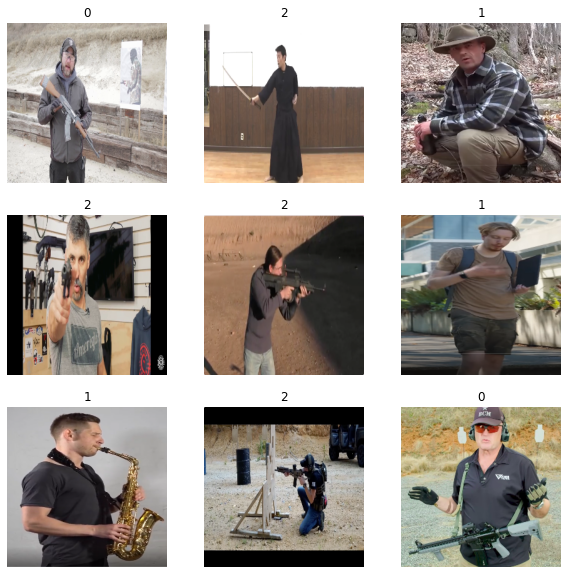

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(int(labels[i]))
      plt.axis("off")

In [49]:
import numpy as np
# train_ds
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    #
    layers.experimental.preprocessing.Normalization(mean=[0.485, 0.456, 0.406], variance=[np.square(0.299), 
                                np.square(0.224), 
                                np.square(0.225)])
  ]
)
# val_ds
data_preprocessing = keras.Sequential([layers.experimental.preprocessing.Normalization(mean=[0.485, 0.456, 0.406], variance=[np.square(0.299), 
                                np.square(0.224), 
                                np.square(0.225)])] 
)

In [2]:
# # showing the rotated, flipped and normalized images that were added to the 
# # original dataset
# #
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 10))
# for images, _ in train_ds.take(1):
#   for i in range(9):
#     augmented_images = data_augmentation(images)
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(augmented_images[0].numpy().astype("uint8"))
#     plt.axis("off")


In [10]:
#Configure the dataset for performance
augmented_train_ds = train_ds.map( lambda x, y: (data_augmentation(x, training=True), y))
preproceesed_val_ds = val_ds.map( lambda x, y: (data_preprocessing(x, training=True), y))

augmented_train_ds = augmented_train_ds.prefetch(buffer_size=32)
preproceesed_val_ds = preproceesed_val_ds.prefetch(buffer_size=32)

# train_ds = train_ds.prefetch(buffer_size=32)
# val_ds = val_ds.prefetch(buffer_size=32)

In [ ]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Please install GPU version of TF


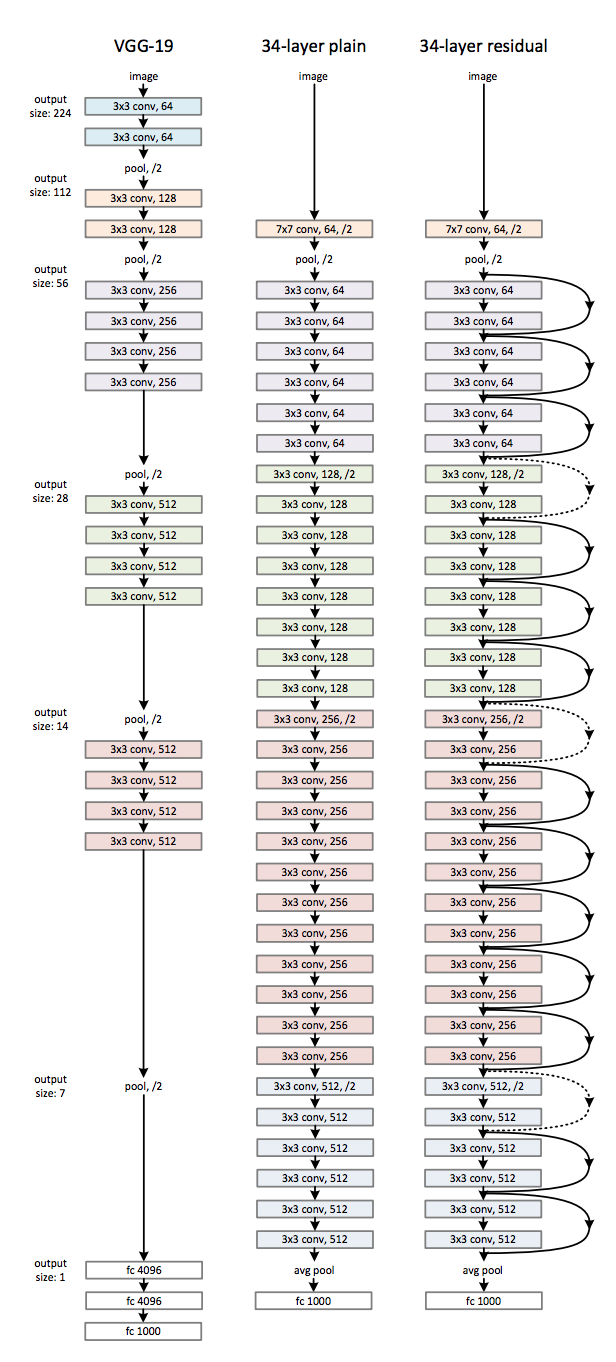

In [ ]:
# # standardization
# # starndardize values from [0, 255] to [0, 1]
# normalization_layer = layers.Rescaling(1./255)
# normalized_ds = augmented_train_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
#34 layer residual
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

classes = len(class_names)
shape = (img_height, img_width, 3)

def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('selu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('selu')(x)
    return x

def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('selu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('selu')(x)
    return x

def ResNet34(shape = (img_height, img_width, 3), num_classes = 3):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    # standardization
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x_input)

    x = tf.keras.layers.ZeroPadding2D((3, 3))(x)# because next one is 7x7
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('selu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)


    # Define size of sub-blocks and initial filter size
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(len(block_layers)): 
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'selu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

In [ ]:
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.layers import Input

# baseModel = ResNet50(weights="imagenet", include_top=False,
# 	input_tensor=Input(shape=(img_height, img_width, 3)))
# # construct the head of the model that will be placed on top of the
# # the base model
# headModel = baseModel.output
# headModel = keras.layers.AveragePooling2D(pool_size=(7, 7))(headModel)
# headModel = keras.layers.Flatten(name="flatten")(headModel)
# headModel = keras.layers.Dense(256, activation="relu")(headModel)
# headModel = keras.layers.Dropout(0.5)(headModel)
# headModel = keras.layers.Dense(len(class_names), activation="softmax")(headModel)
# # place the head FC model on top of the base model (this will become
# # the actual model we will train)


# #model = Model(inputs=baseModel.input, outputs=headModel)
# # # loop over all layers in the base model and freeze them so they will
# # # *not* be updated during the training process
# # for layer in baseModel.layers:
# # 	layer.trainable = False

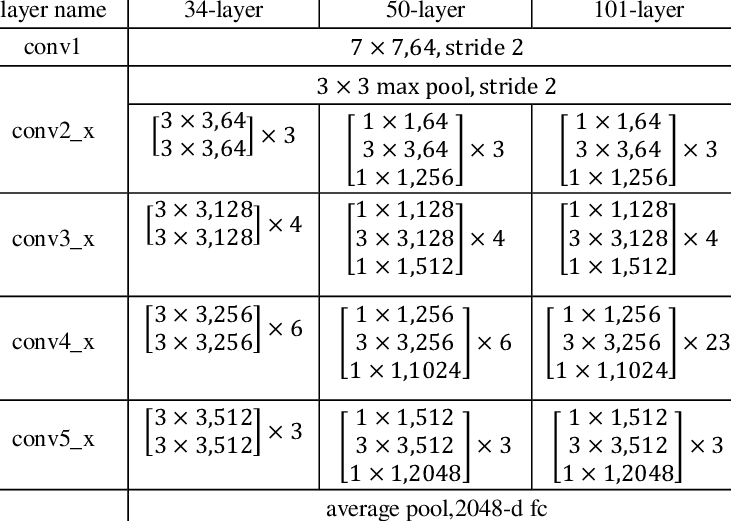

In [ ]:
# from tensorflow.keras.models import Model
# model = Model(inputs=baseModel.input, outputs=headModel)#ResNet34()

In [ ]:
model = ResNet34()#### set to self implemented resnet

In [ ]:
#opimizer
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_accuracy'])


NameError: ignored

In [ ]:
#model.summary()

In [ ]:
#keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 30
history = model.fit(
  augmented_train_ds,
  validation_data=preproceesed_val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


38/38 [==============================] - 69s 1s/step - loss: 1.0347 - sparse_categorical_accuracy: 0.5763 - val_loss: 4.8830 - val_sparse_categorical_accuracy: 0.3960
Epoch 2/30
38/38 [==============================] - 63s 1s/step - loss: 0.8583 - sparse_categorical_accuracy: 0.6216 - val_loss: 1.9798 - val_sparse_categorical_accuracy: 0.5182
Epoch 3/30
38/38 [==============================] - 63s 1s/step - loss: 0.8734 - sparse_categorical_accuracy: 0.6505 - val_loss: 3.0769 - val_sparse_categorical_accuracy: 0.5050
Epoch 4/30
38/38 [==============================] - 65s 2s/step - loss: 0.8793 - sparse_categorical_accuracy: 0.6158 - val_loss: 3.1427 - val_sparse_categorical_accuracy: 0.5083
Epoch 5/30
38/38 [==============================] - 63s 1s/step - loss: 0.7769 - sparse_categorical_accuracy: 0.6678 - val_loss: 1.5943 - val_sparse_categorical_accuracy: 0.5479
Epoch 6/30
38/38 [==============================] - 63s 1s/step - loss: 0.7348 - sparse_categorical_accuracy: 0.6892 - va

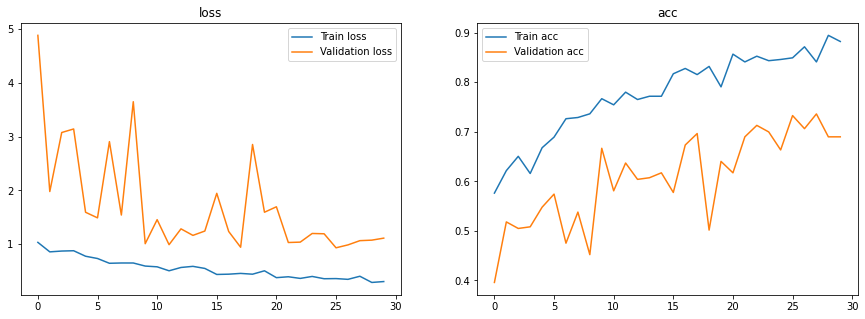

In [ ]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["sparse_categorical_accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_sparse_categorical_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()
show_final_history(history)#

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/better_trained_2')

In [25]:
####load model
import os
import numpy as np
from os import listdir
# make confution matrix
confution_matrix = np.zeros((3,3), dtype=int)


# get the path/directory
from tensorflow import keras
#model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/better_trained_2')

model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/baseline_trained_dropout0.5_batchNorm')


FileNotFoundError: ignored

In [ ]:
import os 
import numpy as np

confusion_matrix_self = np.zeros((3,3), dtype=int)# row = real, col = predict

#path = "/content/drive/My Drive/Colab Notebooks/cs4243NEWdata/"
path_carry = "/content/drive/My Drive/Colab Notebooks/cs4243NEWdata/carrying/"
path_normal = "/content/drive/My Drive/Colab Notebooks/cs4243NEWdata/normal/"
path_threat = "/content/drive/My Drive/Colab Notebooks/cs4243NEWdata/threat/"

dir_list = [path_carry, path_normal, path_threat]

for path in dir_list:
  #each dir from carry, normal, threat
  files = os.listdir(path)# get all img names
  for img_name in files:
    img = keras.preprocessing.image.load_img(path + img_name, target_size = (img_height, img_width, 3))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array, verbose=0)#carraying, normal, threat
    predicted_class = np.argmax(predictions) # 0,1,2
    if(path == path_carry): 
      real_class = 0
    elif(path == path_normal):
      real_class = 1 
    else:
      real_class = 2
    confusion_matrix_self[real_class][predicted_class] +=1
print(confusion_matrix_self)




[[100 318 107]
 [105 268 127]
 [ 84 229 178]]


predicted class:  0


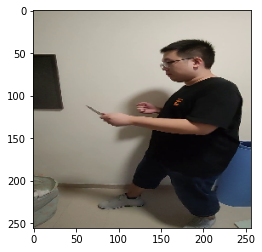

predicted class:  2


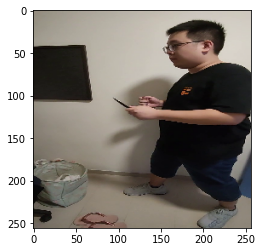

predicted class:  0


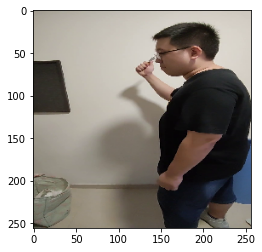

predicted class:  0


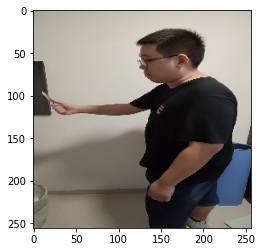

predicted class:  1


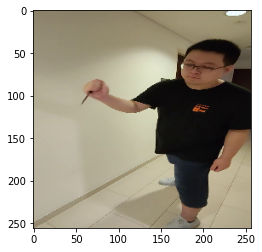

predicted class:  1


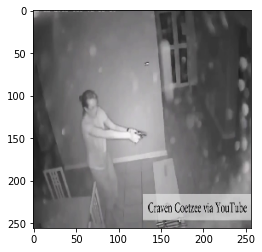

predicted class:  2


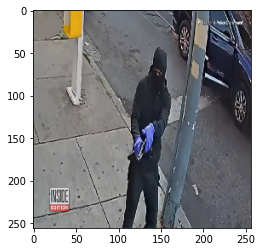

predicted class:  2


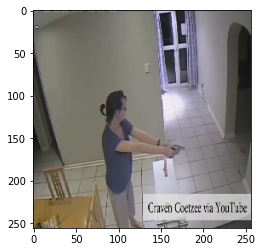

predicted class:  1


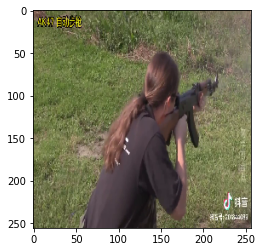

predicted class:  1


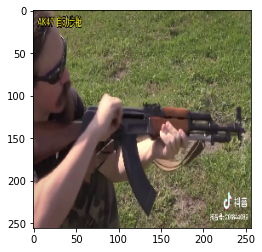

predicted class:  1


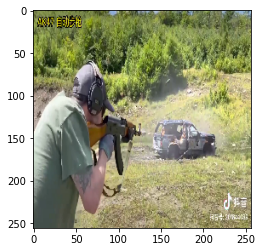

predicted class:  0


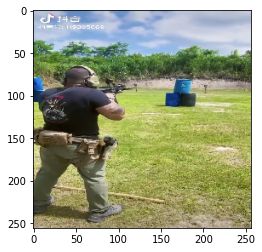

predicted class:  2


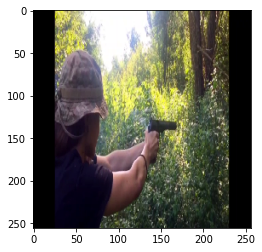

predicted class:  2


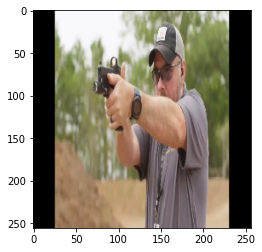

predicted class:  2


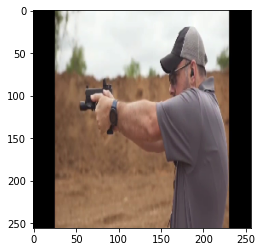

predicted class:  2


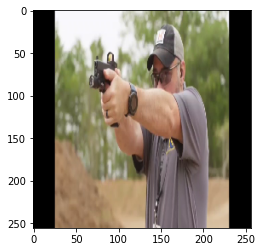

predicted class:  2


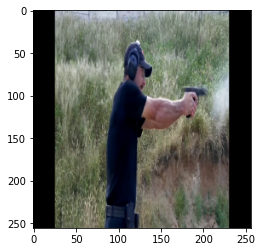

predicted class:  2


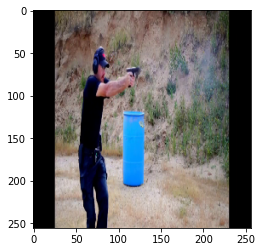

predicted class:  2


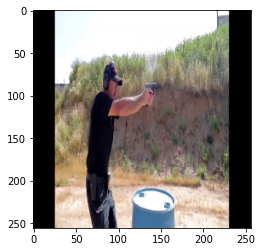

predicted class:  2


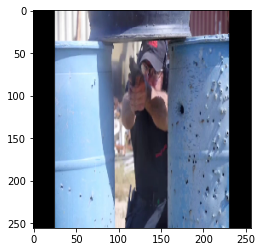

In [ ]:
import matplotlib.pyplot as plt
files = os.listdir(path_threat)# get all img names
for img_name in files[0:20]:
  img = keras.preprocessing.image.load_img(path + img_name, target_size = (img_height, img_width, 3))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array, verbose=0)#carraying, normal, threat
  predicted_class = np.argmax(predictions) # 0,1,2
  print("predicted class: ",predicted_class)
  plt.imshow(img)
  plt.show()
#print(confusion_matrix_self)

In [ ]:
print("correct 0 percentage is:", 100* (confusion_matrix_self[0][0]+confusion_matrix_self[1][1]+confusion_matrix_self[2][2])/np.sum(confusion_matrix_self))

correct 0 percentage is: 36.01583113456464


In [ ]:
print("correct 0 percentage is:", 100* confusion_matrix_self[0][0]/(confusion_matrix_self[0][0]+confusion_matrix_self[0][1]+confusion_matrix_self[0][2]))
print("correct 1 percentage is:", 100* confusion_matrix_self[1][1]/(confusion_matrix_self[1][0]+confusion_matrix_self[1][1]+confusion_matrix_self[1][2]))
print("correct 2 percentage is:", 100* confusion_matrix_self[2][2]/(confusion_matrix_self[2][0]+confusion_matrix_self[2][1]+confusion_matrix_self[2][2]))
###########################################################################################################################

correct 0 percentage is: 19.047619047619047
correct 1 percentage is: 53.6
correct 2 percentage is: 36.25254582484725


In [22]:
len(absolute_path)

305

In [12]:
import traceback
absolute_path

confution_matrix = np.zeros((3,3), dtype=int)
for image_abs_path in absolute_path:
    # check if the image ends with png
    if (image_abs_path.endswith(".png")):
      try:
        img = keras.preprocessing.image.load_img(image_abs_path, target_size = (img_height, img_width, 3))
        img_array = keras.preprocessing.image.img_to_array(img)#from img name to img array 
        img_array = tf.expand_dims(img_array, 0)  # Create batch axis
        #normalization
        img_array = data_preprocessing(img_array)
        #
        predictions = model.predict(img_array, verbose = 0)
        predicted_class = np.argmax(predictions)
        img_class = int(image_abs_path[-5])
        confution_matrix[img_class][predicted_class] +=1
      except Exception:
        print(image_abs_path)
        traceback.print_exc()

In [13]:
confution_matrix

array([[82,  6, 16],
       [ 9, 86,  6],
       [ 7, 12, 81]])

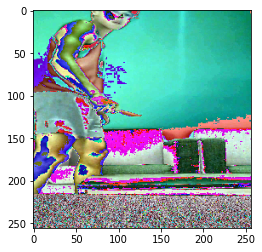

In [27]:
processed = data_preprocessing(img_array)
plt.imshow(processed[0].numpy().astype("uint8"))

In [24]:
sum(sum(confution_matrix))

305

In [ ]:

predictions = model.predict(preproceesed_whole_ds)
predicted_class = np.argmax(predictions, axis=1)####
print(predicted_class)

48/48 [==============================] - 509s 10s/step
[0 0 0 ... 2 2 2]


In [ ]:
labeled_class = np.concatenate([label for img, label in preproceesed_whole_ds], axis = 0)####
print(labeled_class)

[0 0 0 ... 2 2 2]


In [1]:
# # confusion matrix
# # https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix
# # confusion_matrix(labels, predictions)
# # The rows of the matrix represent the labels
# # tf.math.confusion_matrix(labeled_class, predicted_class)

# confusion_matrix = tf.math.confusion_matrix(
#     labeled_class,
#     predicted_class,
#     num_classes=3,
#     weights=None,
#     dtype=tf.dtypes.int32,
#     name=None
# )

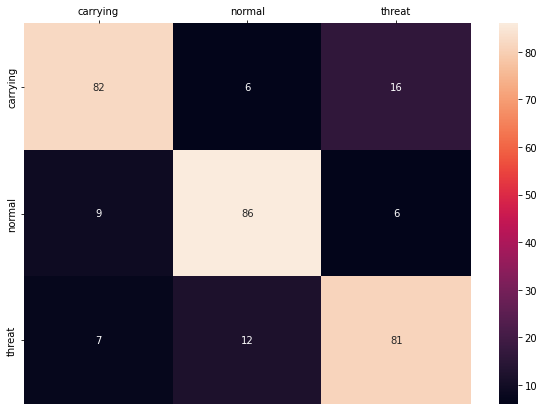

In [14]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

confusion_matrix_np = confution_matrix
from matplotlib import pyplot as plt
classes = ["carrying", "normal", "threat"]
df_cm = pd.DataFrame(confusion_matrix_np, index = [i for i in classes],
                  columns = [i for i in classes])


plt.figure(figsize = (10,7))
ax = sn.heatmap(confusion_matrix_np, annot=True, xticklabels = classes , yticklabels = classes)
ax.xaxis.tick_top()
#ax.set_xlabel('Confusion matrix')

In [ ]:
print("correct 0 percentage is:", 100* confusion_matrix[0][0]/(confusion_matrix[0][0]+confusion_matrix[0][1]+confusion_matrix[0][2]))
print("correct 1 percentage is:", 100* confusion_matrix[1][1]/(confusion_matrix[1][0]+confusion_matrix[1][1]+confusion_matrix[1][2]))
print("correct 2 percentage is:", 100* confusion_matrix[2][2]/(confusion_matrix[2][0]+confusion_matrix[2][1]+confusion_matrix[2][2]))

correct 0 percentage is: tf.Tensor(79.42857142857143, shape=(), dtype=float64)
correct 1 percentage is: tf.Tensor(82.2, shape=(), dtype=float64)
correct 2 percentage is: tf.Tensor(87.37270875763747, shape=(), dtype=float64)
